In this notebook we will be doing the pre-processing and modeling steps to build a model which would predict whether a patient has pneumonia or not using chest X-ray images. 
We will be using convolutional neural networks for predicting the patient status. Convolutional neural networks are commonly used for predictions in image based projects. They are used  due to their ability to extract local features,  with the use of kernels in the convolution layers  that are used to convolute the image to create feature maps. Along with convolutional layers there are pooling layers which extract the most important features and reduce the spatial dimensions.  
We will be comparing two models, one of which is based on transfer learning, which is the Resnet50 model. Resnet50 stands for Residual Net and the model is a 50 layer deep model. In a residual network model, residual blocks are introduced in which in case layers are skipped if they reduce the performance of the network, which is a problem encountered with deep layer models. The model has been trained on ImageNet database.
The other model with be a traditional CNN model that we have built.



Let us import the libraries

In [62]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report


We have seen previously that the training dataset is class imbalanced. In order to help the data be generalized better and deal with class imbalance, we will be using a combination of data augmentation and balancing class weights in the model to deal with it.

Let us load the training, testing and validation data. 

In [2]:
training_folder= '/Users/mks9338/Documents/Course/Capstone_three/chest_xray/train'
testing_folder= '/Users/mks9338/Documents/Course/Capstone_three/chest_xray/test'
validation_folder= '/Users/mks9338/Documents/Course/Capstone_three/chest_xray/val'


We will be using imagedata generator for the training and validation data, to creates modified images in real time while model is being trained. All the images will have normalized pixels by rescaling as part of imae processing. The test data set which we will be testing our fitted model on will have normalized pixels as part of the pre-processing 

In [3]:
train_val_generator = ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.3,rotation_range=5)
test_generator = ImageDataGenerator(rescale=1./255)

Using flow from directory function of image generator to take the files directly from the folder and also resizing the images to 224, 224. As data augmentation takes place, the images are chosen shuffled and the image remains three channel.

In [4]:
train = train_val_generator.flow_from_directory(training_folder, batch_size=64, target_size=(224,224), color_mode="rgb",class_mode="binary", shuffle=True, seed=42)

Found 5216 images belonging to 2 classes.


In [5]:
val = train_val_generator.flow_from_directory(validation_folder,
                                               batch_size=4,
                                               target_size=(224,224),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 16 images belonging to 2 classes.


In [6]:
test = test_generator.flow_from_directory(testing_folder,
                                          batch_size=32,
                                          target_size=(224,224),
                                          color_mode="rgb",
                                          class_mode="binary")


Found 624 images belonging to 2 classes.


We will  be using the sklearn class weight function to allow balancing of the training dataset. The class weight function uses the inverse proportion of class frequency

In [7]:

class_weights = compute_class_weight(
    'balanced',                  # Automatically balance the weights based on class frequency
    classes=np.unique(train.classes),  # All unique class labels
    y=train.classes         # All the labels in the dataset
)

# Convert the class weights to a dictionary format
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(class_weight_dict)


{0: 1.9448173005219984, 1: 0.6730322580645162}


We will use the transfer learning approach here using the resnet50 model with frozen weights chosen from the training on the imagenet dataset. The last dense layers will be removed and  we will be writing our own dense layers due to the binary classification required.

In [8]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (224,224,3), include_top = False)
model = Sequential()

model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False
    
model.add(Flatten())

model.add(Dense(units = 128, activation = "relu"))

model.add(Dense(units = 1, activation = "sigmoid"))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,410,113
Trainable params: 12,845,313
Non-trainable params: 23,564,800
_________________________________________________________________



For optimization of weights, biases and learning rate we used the Adam optimizer, which is commonly used in image based cnn networks. Adam optimizer calculates changes based on using a combination of stochastic gradient descent and momentum.We used the binary cross entropy loss function, which is commonly used in classification neural network problems 

In [24]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
early_stopping = EarlyStopping(
    monitor='val_accuracy',       
    patience=5,               
    restore_best_weights=True 
)
history=model.fit(train,validation_data=val, epochs=20, class_weight=class_weight_dict,
    callbacks=[early_stopping])

Epoch 1/20
82/82 [==============================] - 153s 2s/step - loss: 0.1646 - accuracy: 0.9500 - val_loss: 0.4648 - val_accuracy: 0.7500
Epoch 2/20
82/82 [==============================] - 147s 2s/step - loss: 0.1232 - accuracy: 0.9548 - val_loss: 1.0470 - val_accuracy: 0.6250
Epoch 3/20
82/82 [==============================] - 145s 2s/step - loss: 0.1021 - accuracy: 0.9638 - val_loss: 0.3229 - val_accuracy: 0.8750
Epoch 4/20
82/82 [==============================] - 151s 2s/step - loss: 0.0922 - accuracy: 0.9647 - val_loss: 0.5251 - val_accuracy: 0.6875
Epoch 5/20
82/82 [==============================] - 150s 2s/step - loss: 0.0813 - accuracy: 0.9689 - val_loss: 0.4662 - val_accuracy: 0.8125
Epoch 6/20
82/82 [==============================] - 150s 2s/step - loss: 0.0784 - accuracy: 0.9711 - val_loss: 0.5571 - val_accuracy: 0.8125
Epoch 7/20
82/82 [==============================] - 146s 2s/step - loss: 0.0694 - accuracy: 0.9741 - val_loss: 0.3032 - val_accuracy: 0.8750
Epoch 8/20
82

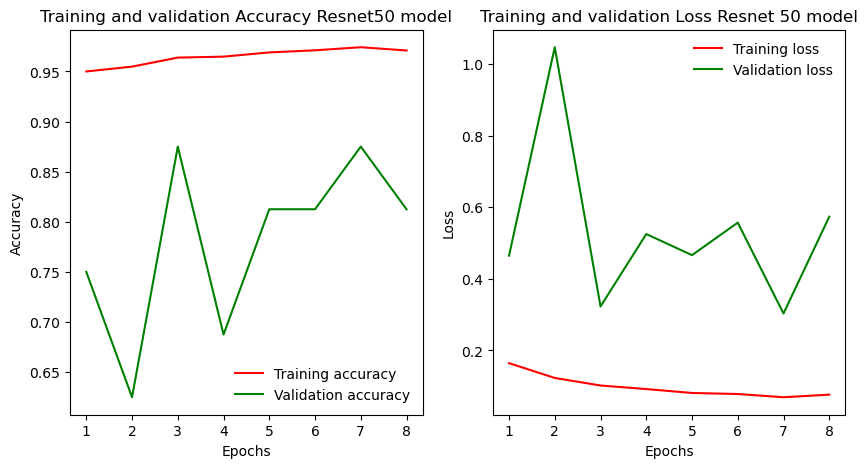

In [44]:
fig,axs=plt.subplots(1,2,figsize=(10,5))

axs[0].plot(list(range(1,9)),history.history["accuracy"],"r",label="Training accuracy")
axs[0].plot(list(range(1,9)),history.history["val_accuracy"],"g",label="Validation accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Training and validation Accuracy Resnet50 model")
leg=axs[0].legend(loc="best")
leg.get_frame().set_alpha(0)
axs[1].plot(list(range(1,9)),history.history["loss"],"r",label="Training loss")
axs[1].plot(list(range(1,9)),history.history["val_loss"],"g",label="Validation loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Training and validation Loss Resnet 50 model")
leg1=axs[1].legend(loc="best")
leg1.get_frame().set_alpha(0)
plt.savefig('/Users/mks9338/Documents/Course/Capstone_three/training_validation_loss.png')
plt.show()

The model does well on training and validation accuracy based on the weights acquired at the highest validation accuracy: Training accuracy: 96.4% and Validation accuracy: 87.5% respectively

We will also test another model before deciding on using the Resnetv50 model for training. A CNN model was developed with three blocks with similar design. In the first block, we have  two convolution layers with kernel size of 3x3 with a total of 32 kernels. The activation function used in cnn is the non-linear RELU function, which returns the input value if it is positive and 0 otherwise. This helps it overcome the vanishing gradient problem with other functions during backpropogation. Batch normalization to prevent overfitting was carried out in between the two layers. We then followed it up with max-pooling to reduce the number of features wth the pol_size (2,2). 
This was followed by two more blocks with similar design except using 64 and 128 blocks

 The layers were then flattened and then the nodes from the second convolutional layer passed onto a  dense network with 128 neurons and the RELU activation function. The output was passed onto a single neuron which gave a probability score to classify an image as pneumonia or normal (1,0). Sigmoid function is used so that the output is a probability score.

In [86]:
model1 = Sequential()

model1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [87]:
history1=model1.fit(train,validation_data=val, epochs=20,class_weight=class_weight_dict,
    callbacks=[early_stopping])

Epoch 1/20
82/82 [==============================] - 349s 4s/step - loss: 1.9970 - accuracy: 0.8533 - val_loss: 3.6184 - val_accuracy: 0.5000
Epoch 2/20
82/82 [==============================] - 312s 4s/step - loss: 0.2002 - accuracy: 0.9197 - val_loss: 4.2988 - val_accuracy: 0.5000
Epoch 3/20
82/82 [==============================] - 306s 4s/step - loss: 0.1746 - accuracy: 0.9308 - val_loss: 7.4073 - val_accuracy: 0.5000
Epoch 4/20
82/82 [==============================] - 361s 4s/step - loss: 0.1572 - accuracy: 0.9383 - val_loss: 3.2017 - val_accuracy: 0.5000
Epoch 5/20
82/82 [==============================] - 374s 5s/step - loss: 0.1634 - accuracy: 0.9388 - val_loss: 3.5816 - val_accuracy: 0.5000
Epoch 6/20
82/82 [==============================] - 352s 4s/step - loss: 0.1569 - accuracy: 0.9400 - val_loss: 1.0907 - val_accuracy: 0.5625
Epoch 7/20
82/82 [==============================] - 348s 4s/step - loss: 0.1563 - accuracy: 0.9381 - val_loss: 0.7516 - val_accuracy: 0.7500
Epoch 8/20
82

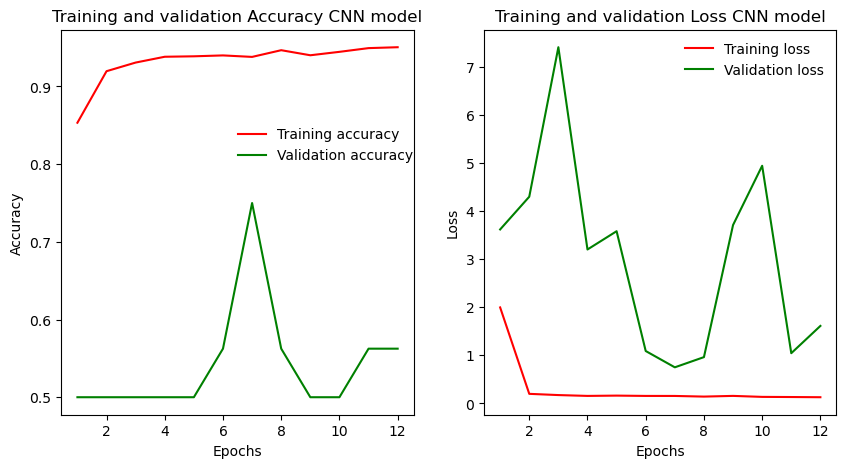

In [104]:
fig,axs=plt.subplots(1,2,figsize=(10,5))

axs[0].plot(list(range(1,13)),history1.history["accuracy"],"r",label="Training accuracy")
axs[0].plot(list(range(1,13)),history1.history["val_accuracy"],"g",label="Validation accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Training and validation Accuracy CNN model")
leg=axs[0].legend(loc="center",bbox_to_anchor=(0.75, 0.7))
leg.get_frame().set_alpha(0)
axs[1].plot(list(range(1,13)),history1.history["loss"],"r",label="Training loss")
axs[1].plot(list(range(1,13)),history1.history["val_loss"],"g",label="Validation loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Training and validation Loss CNN model")
leg1=axs[1].legend(loc="best")
leg1.get_frame().set_alpha(0)
plt.savefig('/Users/mks9338/Documents/Course/Capstone_three/training_validation_loss_CNN.png')
plt.show()

The validation accuracy is lower with the CNN model. Even with the best weights, the validation accuracy is 75.0% 

We will use the resent50 model on our test data set

In [80]:
Test_loss, Test_accuracy = model.evaluate(test)
print(f'Test Loss: {Test_loss}')
print(f'Test Accuracy: {Test_accuracy}')

20/20 [==============================] - 16s 779ms/step - loss: 0.1871 - accuracy: 0.9375
Test Loss: 0.18714091181755066
Test Accuracy: 0.9375


The test accuracy is 93.8% using the resnet50 model.